In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()
from matplotlib.pyplot import rc_context

Memory usage: current 0.21 GB, difference +0.21 GB
scanpy==1.10.2 anndata==0.10.8 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
import decoupler as dc

In [4]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

In [5]:
import matplotlib as mpl
mpl.rc("font", family = "Arial")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42


In [6]:
#load data with leiden
#home_dir = os.path.expanduser("~")
current_directory = os.getcwd()
adata = sc.read_h5ad(current_directory+"/backups/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad")

In [7]:
#Loading obs
current_directory = os.getcwd()
# overwrite obs with the most recent version
filename = current_directory+"/backups/anno_obs_info_86447x39_250127_18h19.npz"
encoding = "latin1"

with np.load(filename, encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

In [8]:
obs_cell_type_sub_prolif_anno = obs[["barcode", "library", "cell_type_sub_prolif_anno"]]
updated_obs = adata.obs.merge(obs_cell_type_sub_prolif_anno, on=["library", "barcode"], how="left")
adata.obs = updated_obs



In [11]:
#subset adata

select_cell_type = "Aged Neutrophils"


select_control_sample = "KC"
select_condition_sample = "UL"


select_sample = [
    select_condition_sample,
    select_control_sample
]
sample_mask = adata.obs["sample"].isin(select_sample)



In [12]:
adata = adata[sample_mask].copy()

/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col = "sample_code",
    groups_col = "cell_type_sub_prolif_anno",
    layer = "counts",
    mode = "sum",
    min_cells = 10,
    min_counts = 1000
)
pdata

AnnData object with n_obs × n_vars = 258 × 31931
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo'
    layers: 'psbulk_props'

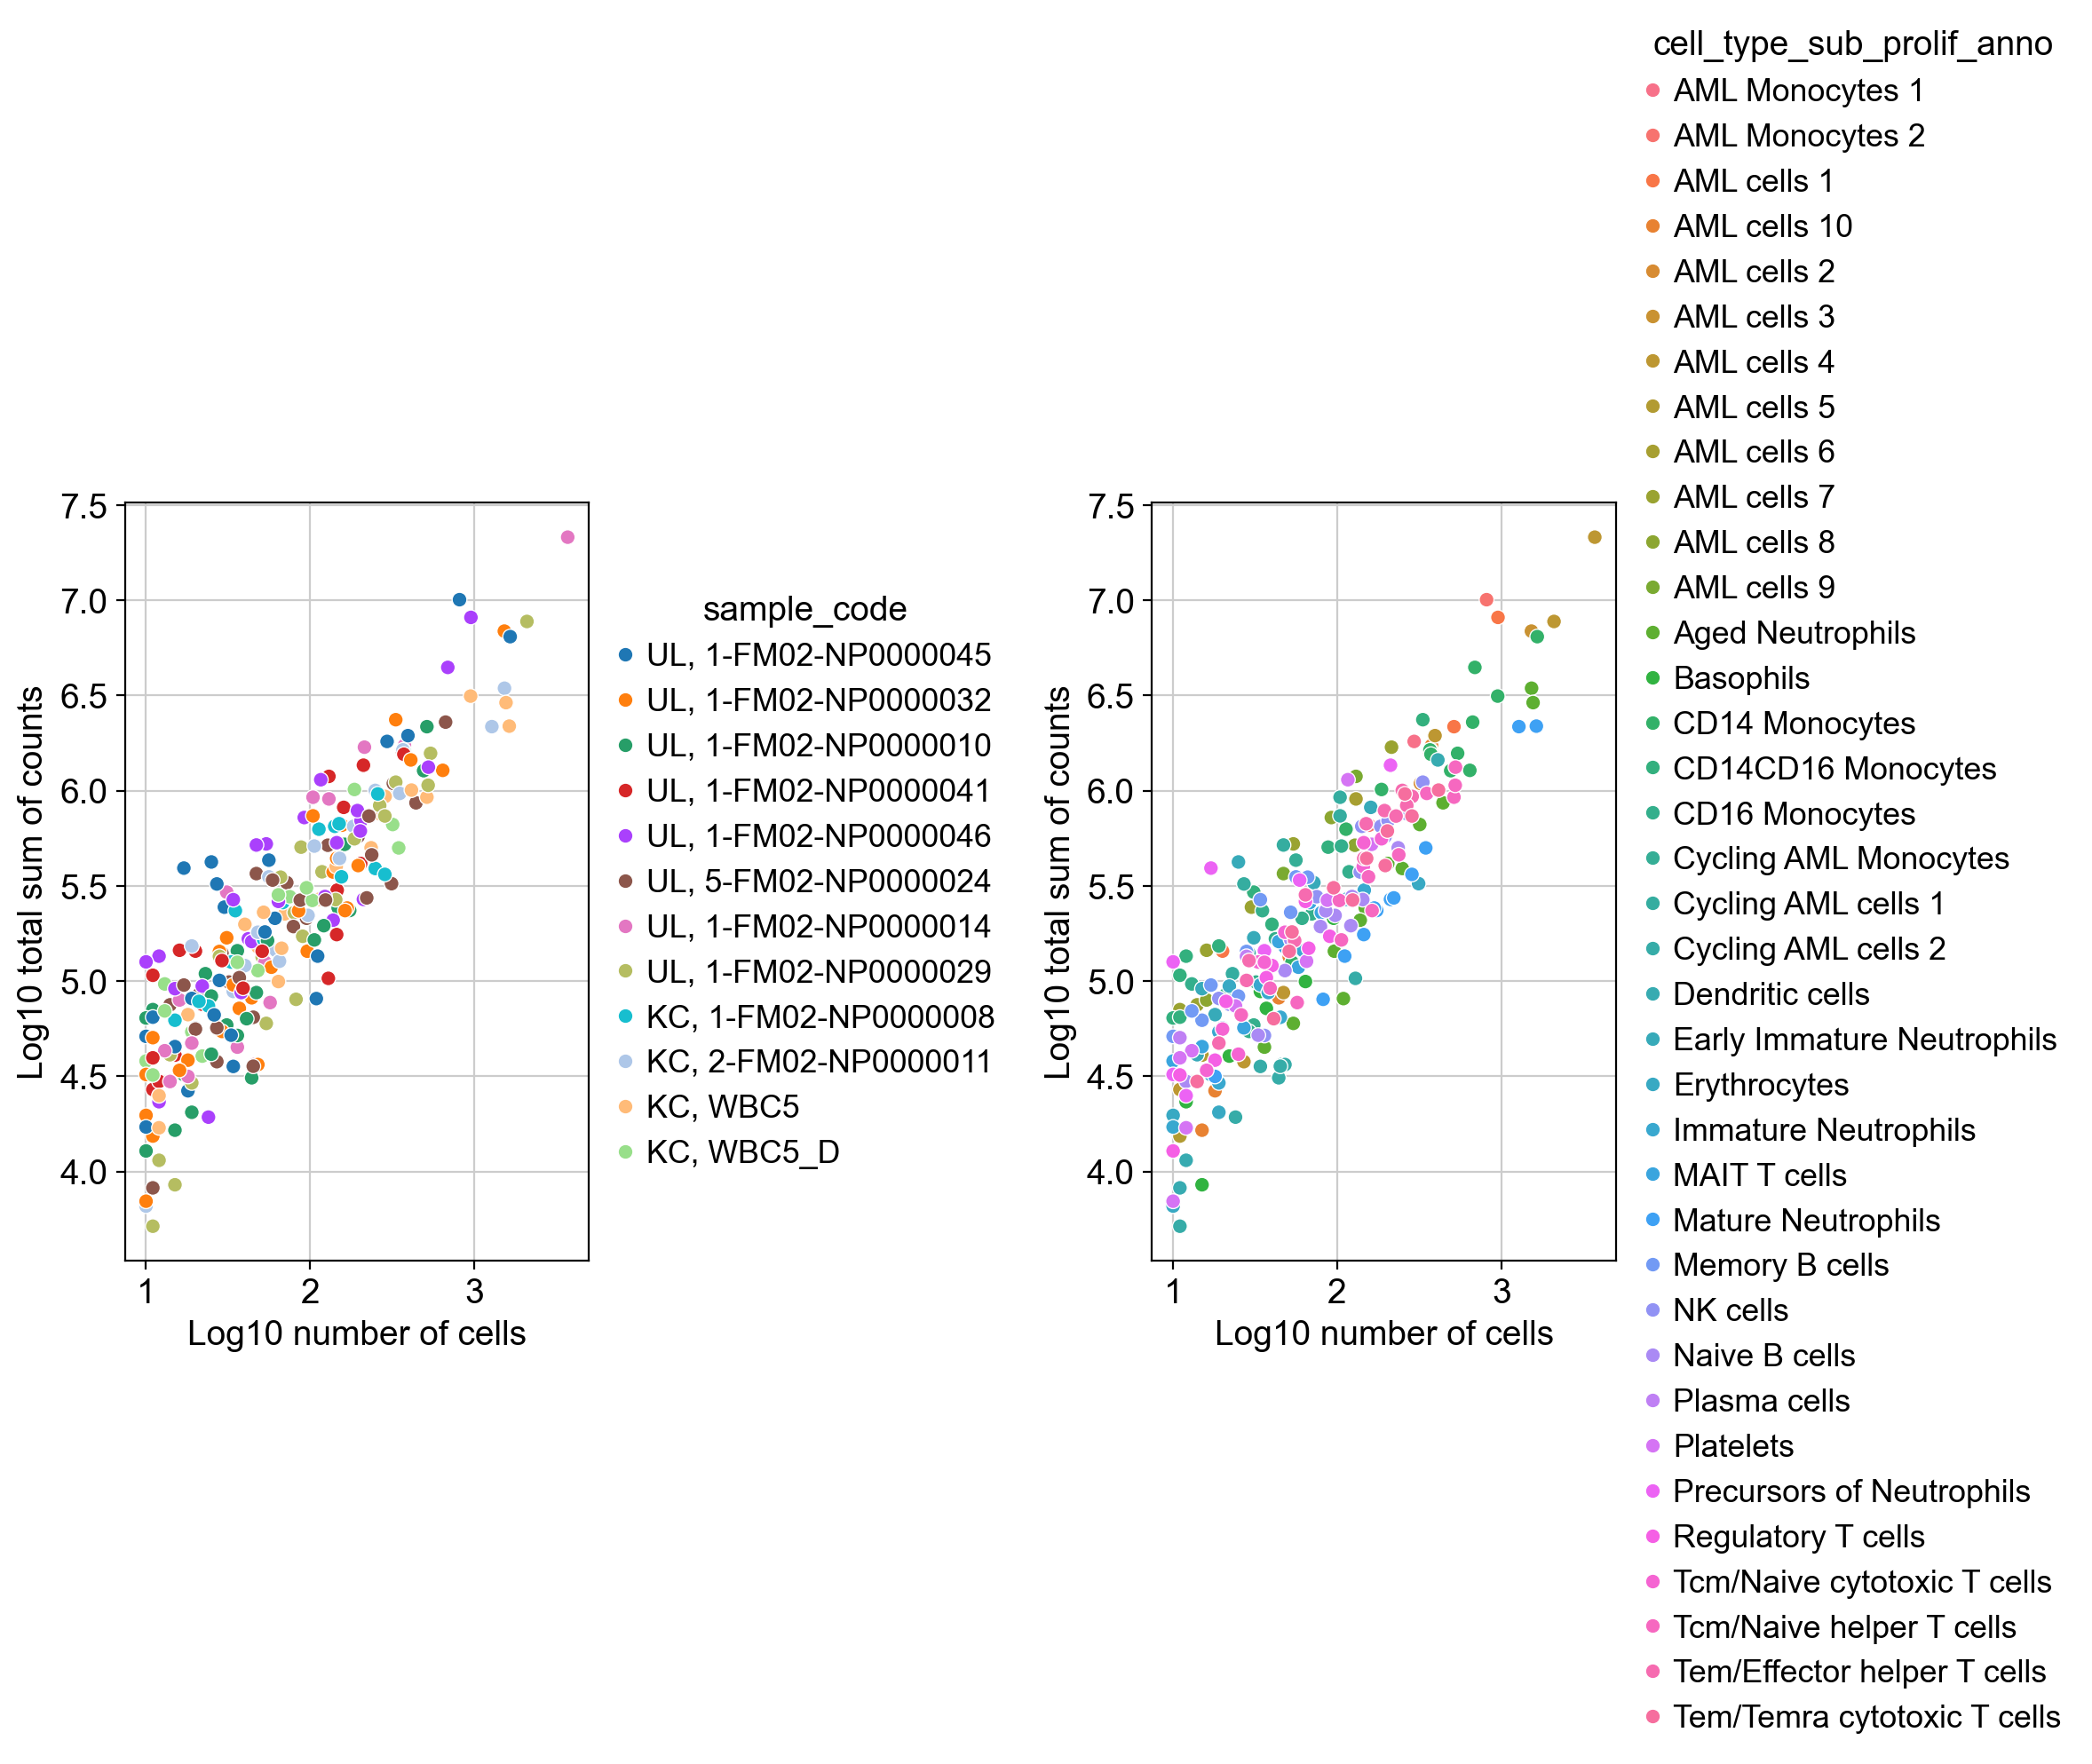

In [16]:
dc.plot_psbulk_samples(pdata, groupby=["sample_code", "cell_type_sub_prolif_anno"], figsize=(12, 9))

In [17]:
pdata

AnnData object with n_obs × n_vars = 258 × 31931
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo'
    layers: 'psbulk_props'

In [18]:
# Store raw counts in layers
pdata.layers["counts"] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum = 1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value = 10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, "counts", X_layer_key=None, inplace=True)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


In [19]:
pdata

AnnData object with n_obs × n_vars = 258 × 31931
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [20]:
# Select Neutrophils profiles
print(select_cell_type)
neutrophils = pdata[pdata.obs["cell_type_sub_prolif_anno"] == select_cell_type].copy()

Aged Neutrophils


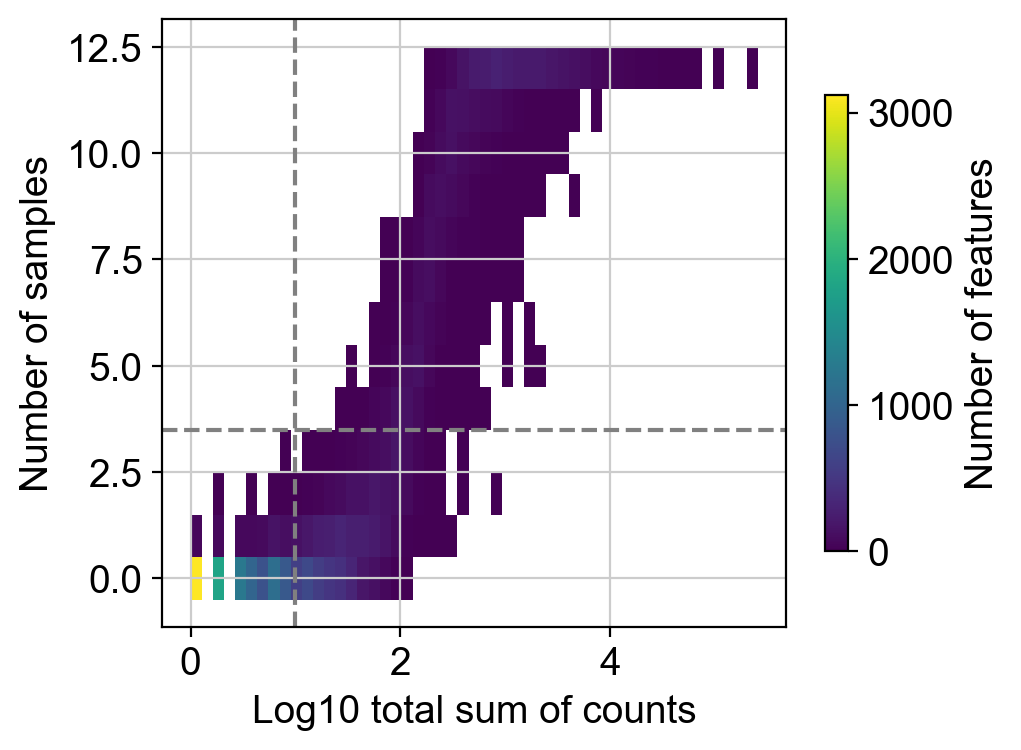

In [21]:
dc.plot_filter_by_expr(neutrophils, group = "sample", min_count = 5, min_total_count = 10)


In [22]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(neutrophils, group = "sample", min_count = 5, min_total_count = 10)

# Filter by these genes
neutrophils = neutrophils[:, genes].copy()
neutrophils


AnnData object with n_obs × n_vars = 12 × 6175
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [23]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [24]:
neutrophils.obs["sample"].unique()

array(['KC', 'UL'], dtype=object)

In [25]:
# Build DESeq2 object
inference = DefaultInference(n_cpus = 8)
dds = DeseqDataSet(
    adata = neutrophils,
    design_factors = "sample",
    ref_level = ["sample", select_control_sample],
    refit_cooks = True,
    inference = inference,
)

In [26]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.73 seconds.

Fitting dispersion trend curve...
... done in 0.08 seconds.

Fitting MAP dispersions...
... done in 0.60 seconds.

Fitting LFCs...
... done in 0.51 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 29 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [27]:
# Extract contrast between AML vs HD
stat_res = DeseqStats(
    dds,
    contrast=["sample", select_condition_sample, select_control_sample],
    inference = inference,
)

In [28]:
# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 0.19 seconds.



Log2 fold change & Wald test p-value: sample UL vs KC
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A3GALT2   7.320960       -0.447698  0.561593 -0.797192  0.425340  0.685294
AAGAB    14.497029        0.922108  0.434315  2.123131  0.033743  0.171888
AAK1     68.514803        1.079796  0.309488  3.488972  0.000485  0.013732
AAMDC     5.755275        0.377844  0.618615  0.610790  0.541339  0.766565
AATF     40.112674       -0.012151  0.283295 -0.042891  0.965788  0.990263
...            ...             ...       ...       ...       ...       ...
ZXDC     43.314934        0.261010  0.297171  0.878316  0.379772  0.649864
ZYG11B   22.967844       -0.282774  0.330597 -0.855344  0.392361  0.658092
ZYX      69.855066       -0.325698  0.294756 -1.104973  0.269171  0.553770
ZZEF1    66.515705        0.302927  0.279631  1.083307  0.278672  0.563076
ZZZ3      7.484347        0.965190  0.522603  1.846891  0.064763  0.251634

[6175 rows x 6 columns]


In [29]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A3GALT2,7.320960,-0.447698,0.561593,-0.797192,0.425340,0.685294
AAGAB,14.497029,0.922108,0.434315,2.123131,0.033743,0.171888
AAK1,68.514803,1.079796,0.309488,3.488972,0.000485,0.013732
AAMDC,5.755275,0.377844,0.618615,0.610790,0.541339,0.766565
AATF,40.112674,-0.012151,0.283295,-0.042891,0.965788,0.990263
...,...,...,...,...,...,...
ZXDC,43.314934,0.261010,0.297171,0.878316,0.379772,0.649864
ZYG11B,22.967844,-0.282774,0.330597,-0.855344,0.392361,0.658092
ZYX,69.855066,-0.325698,0.294756,-1.104973,0.269171,0.553770
ZZEF1,66.515705,0.302927,0.279631,1.083307,0.278672,0.563076


In [30]:
# Export volcano genes
results_df.to_csv("dge/pseudobulk_volcano_aged_neutrophils_AML_vs_HD.csv")

results_df_sorted = results_df.copy()
results_df_sorted[results_df_sorted["padj"] < 0.05].sort_values(by = "log2FoldChange", ascending=False, key=abs).to_excel("dge/pseudobulk_volcano_aged_neutrophils_AML_vs_HD_filtered_by_padj.xlsx")


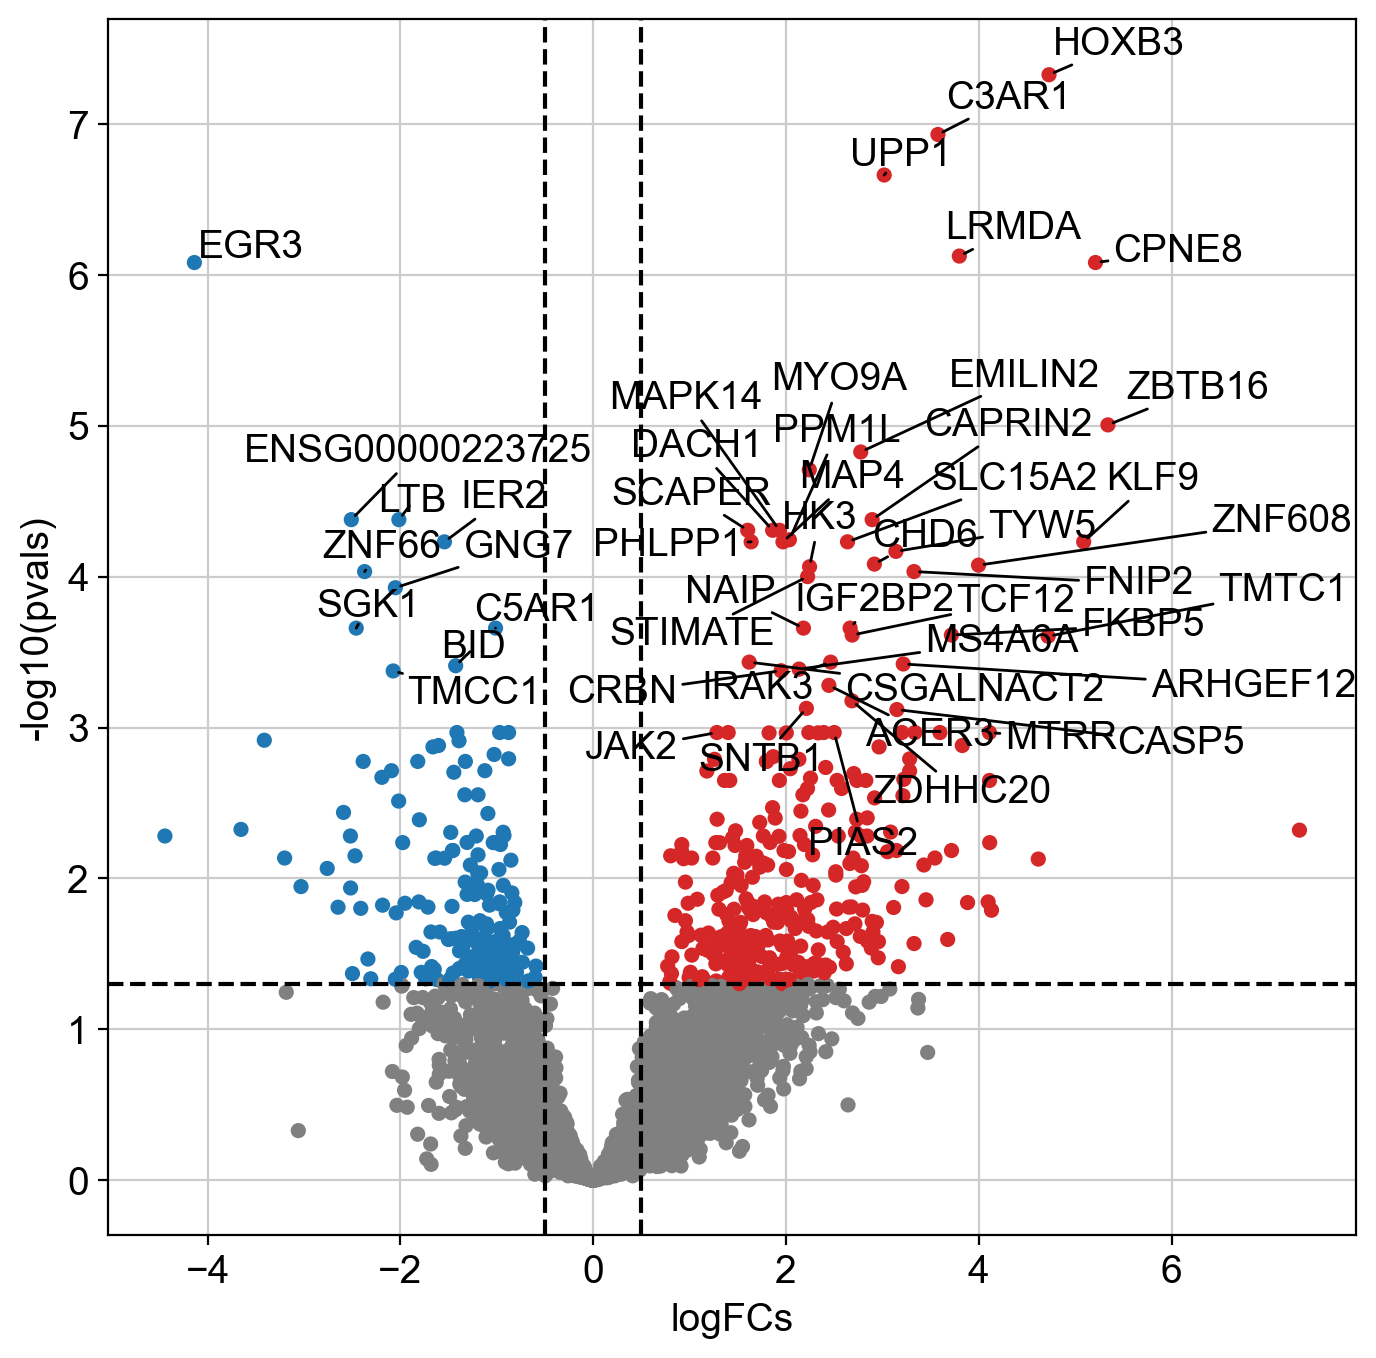

In [33]:
fig = dc.plot_volcano_df(
    results_df,
    x = "log2FoldChange",
    y = "padj",
    top = 50,
    figsize = (8, 8), return_fig = True
)


In [8]:
print(select_cell_type)
mat = results_df[["stat"]].T.rename(index={"stat": select_cell_type})
mat

Aged Neutrophils


,A3GALT2,AAGAB,AAK1,AAMDC,AATF,AATK,ABAT,ABCA1,ABCA5,ABCA7,...,ZRANB2,ZRSR2,ZSCAN32,ZSWIM6,ZSWIM8,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Aged Neutrophils,-0.797192,2.123131,3.488972,0.61079,-0.042891,-1.443605,-0.429864,2.25058,-0.093872,-2.693966,...,1.208376,0.522439,-0.69092,-0.571065,0.429223,0.878316,-0.855344,-1.104973,1.083307,1.846891


# ORA

In [10]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [13]:
# Filter by hallmark
msigdb_filtered = msigdb[msigdb["collection"]=="hallmark"]

# Remove duplicated entries
msigdb_filtered = msigdb_filtered[~msigdb_filtered.duplicated(["geneset", "genesymbol"])]

# Rename
msigdb_filtered.loc[:, "geneset"] = [name.split("HALLMARK_")[1] for name in msigdb_filtered["geneset"]]

msigdb_filtered

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,PANCREAS_BETA_CELLS
1450526,GCG,hallmark,PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,PANCREAS_BETA_CELLS


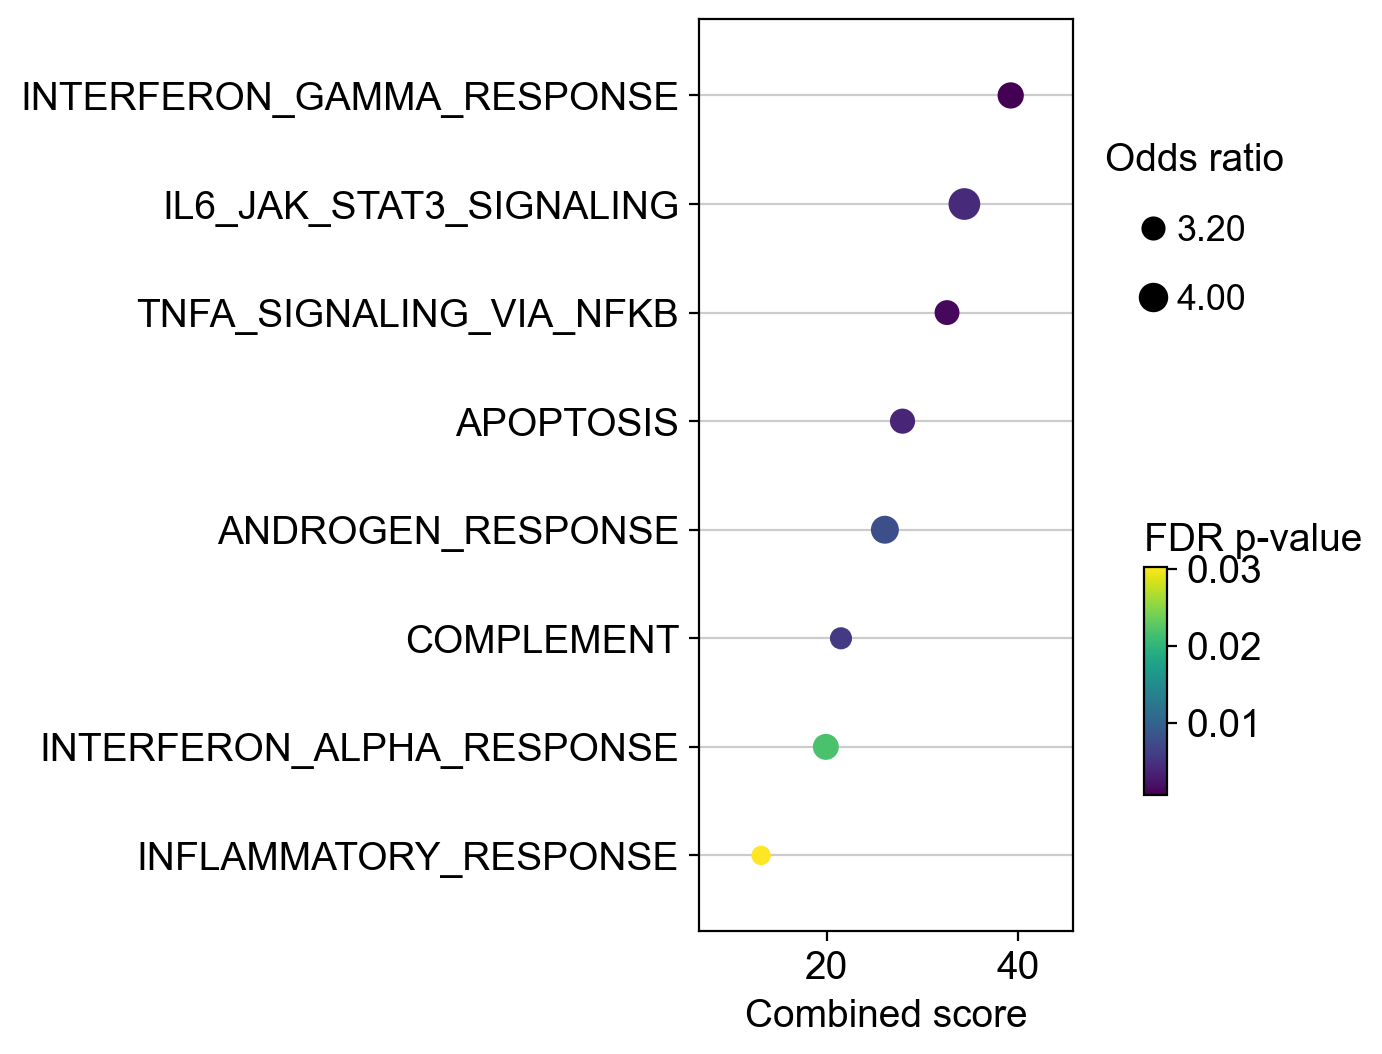

In [42]:
try:
    
    # Infer enrichment with ora using significant deg
    top_genes = results_df[(results_df["padj"] < 0.05)]

    
    # Run ora
    enr_pvals = dc.get_ora_df(
        df = top_genes,
        net = msigdb_filtered,
        source = "geneset",
        target = "genesymbol"
    )
    
    enr_pvals_select = enr_pvals[(enr_pvals["FDR p-value"] < 0.05)].sort_values("Combined score", ascending=False)
    
    dc.plot_dotplot(
        enr_pvals_select,
        x = "Combined score",
        y = "Term",
        s = "Odds ratio", 
        c = "FDR p-value",
        cmap = "viridis",
        scale = 0.4,
        figsize=(3, 6)
    )

except Exception as e:
    print(f"Error ignored: {e}")


# GSEA

In [14]:
gsea_hallmark = dc.get_gsea_df(results_df, stat = "stat", net = msigdb_filtered, source="geneset", target="genesymbol")

In [16]:
gsea_hallmark.to_excel("gsea/gsea_aged_neutrophils.xlsx")

In [44]:
gsea_hallmark.sort_values(by = "FDR p-value").head(10)

,Term,ES,NES,NOM p-value,FDR p-value,Set size,Tag %,Rank %,Leading edge
44,TNFA_SIGNALING_VIA_NFKB,-0.369995,-1.806656,0.000000,0.000000,110,0.327273,0.135223,RELA;EGR3;MAFF;IRF1;CXCL1;KLF2;SAT1;DUSP1;TNFA...
1,ALLOGRAFT_REJECTION,-0.377324,-1.750198,0.000000,0.000000,90,0.311111,0.150607,STAT1;LCP2;CSK;HCLS1;SRGN;HDAC9;LTB;TAPBP;HLA-...
47,UV_RESPONSE_UP,-0.387903,-1.729313,0.000000,0.000000,68,0.411765,0.207935,TMBIM6;IRF1;HLA-F;TUBA4A;DNAJA1;ARRB2;JUNB;PTP...
26,INTERFERON_GAMMA_RESPONSE,-0.326361,-1.684199,0.000000,0.000000,131,0.335878,0.179595,STAT1;CSF2RB;LCP2;RNF31;IRF1;NMI;PSME2;PSMB9;T...
6,APOPTOSIS,-0.339413,-1.592841,0.004975,0.041459,84,0.309524,0.166154,RELA;IGF2R;EGR3;BCAP31;IRF1;BAX;NEDD9;SAT1;CAS...
25,INTERFERON_ALPHA_RESPONSE,-0.368249,-1.661698,0.004717,0.041459,74,0.351351,0.187854,RNF31;IRF1;NMI;PSME2;PSMB9;CASP8;TRIM21;IFIH1;...
42,SPERMATOGENESIS,0.532480,1.670625,0.010160,0.072569,26,0.346154,0.142024,EZH2;MLLT10;SPATA6;PGS1;STRBP;MTOR;PIAS2;CSNK2...
31,MYC_TARGETS_V1,0.356576,1.448262,0.017032,0.106448,107,0.448598,0.302348,RPL6;CCT4;RPLP0;RPS5;PSMA6;UBA2;NAP1L1;EIF3D;C...
46,UV_RESPONSE_DN,0.375029,1.434184,0.031486,0.174923,63,0.301587,0.208259,ATP2C1;DLG1;ANXA4;MIOS;PRKCE;PRKCA;ATXN1;MAP2K...
41,REACTIVE_OXYGEN_SPECIES_PATHWAY,-0.366346,-1.411263,0.042254,0.211268,33,0.272727,0.121619,JUNB;IPCEF1;LSP1;SOD2;EGLN2;HMOX2;G6PD;CDKN2D;...


TNFA_SIGNALING_VIA_NFKB
ALLOGRAFT_REJECTION
UV_RESPONSE_UP
INTERFERON_GAMMA_RESPONSE
APOPTOSIS
INTERFERON_ALPHA_RESPONSE


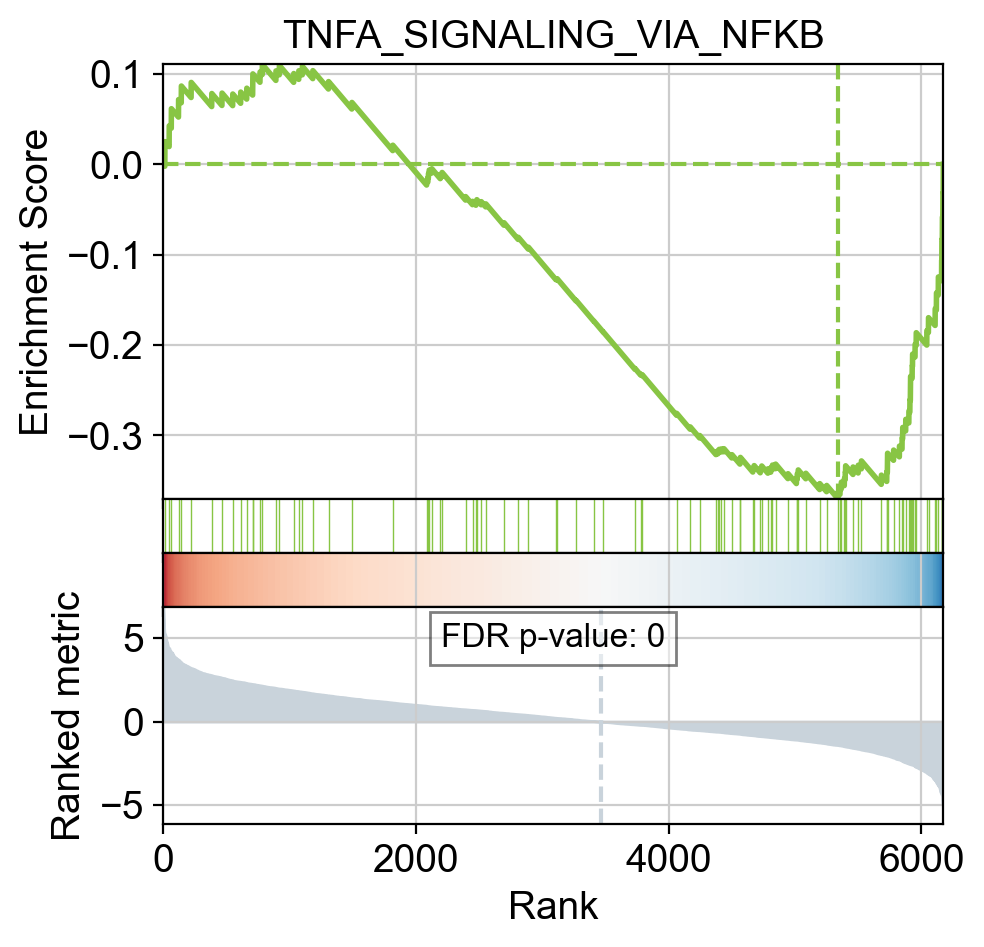

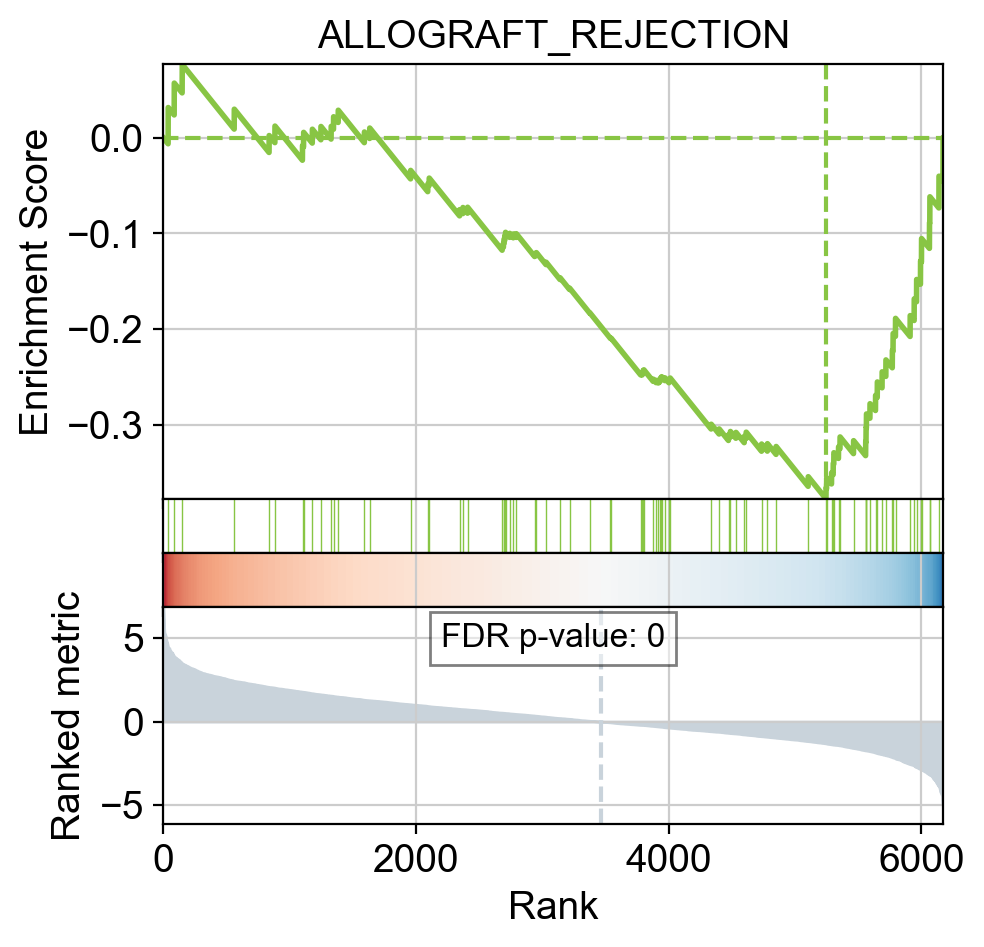

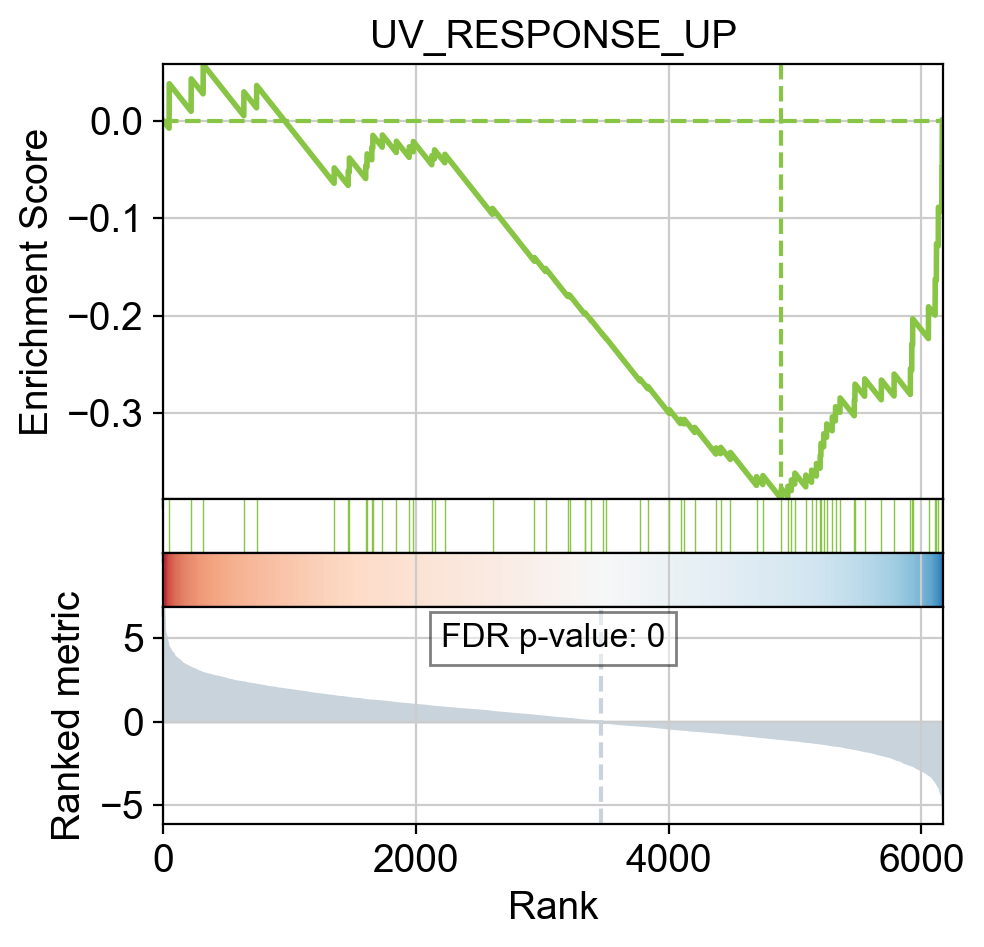

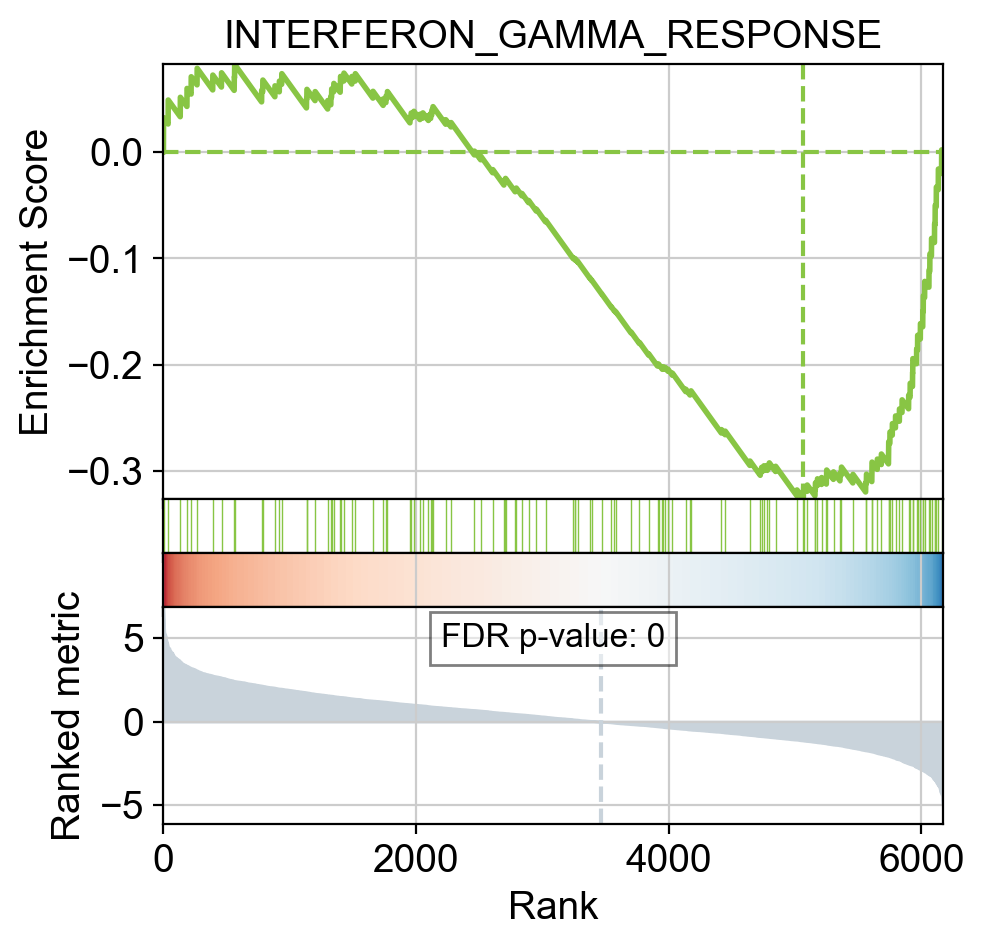

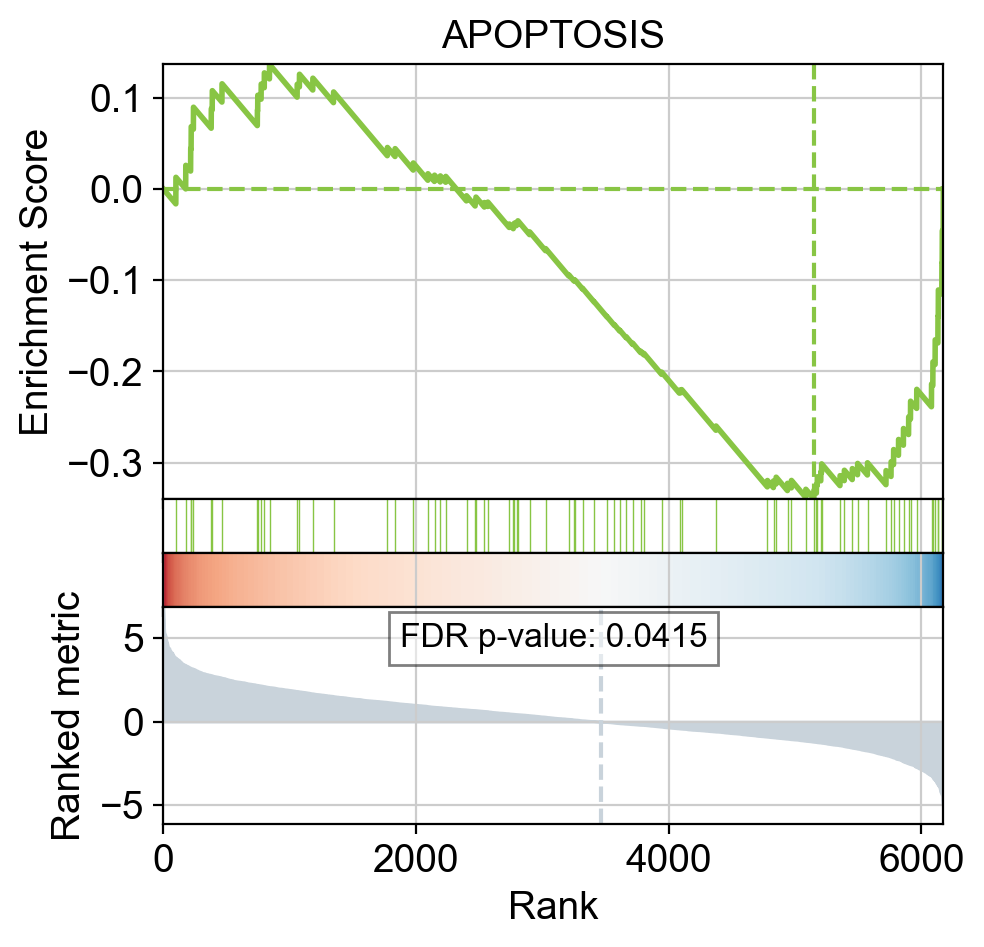

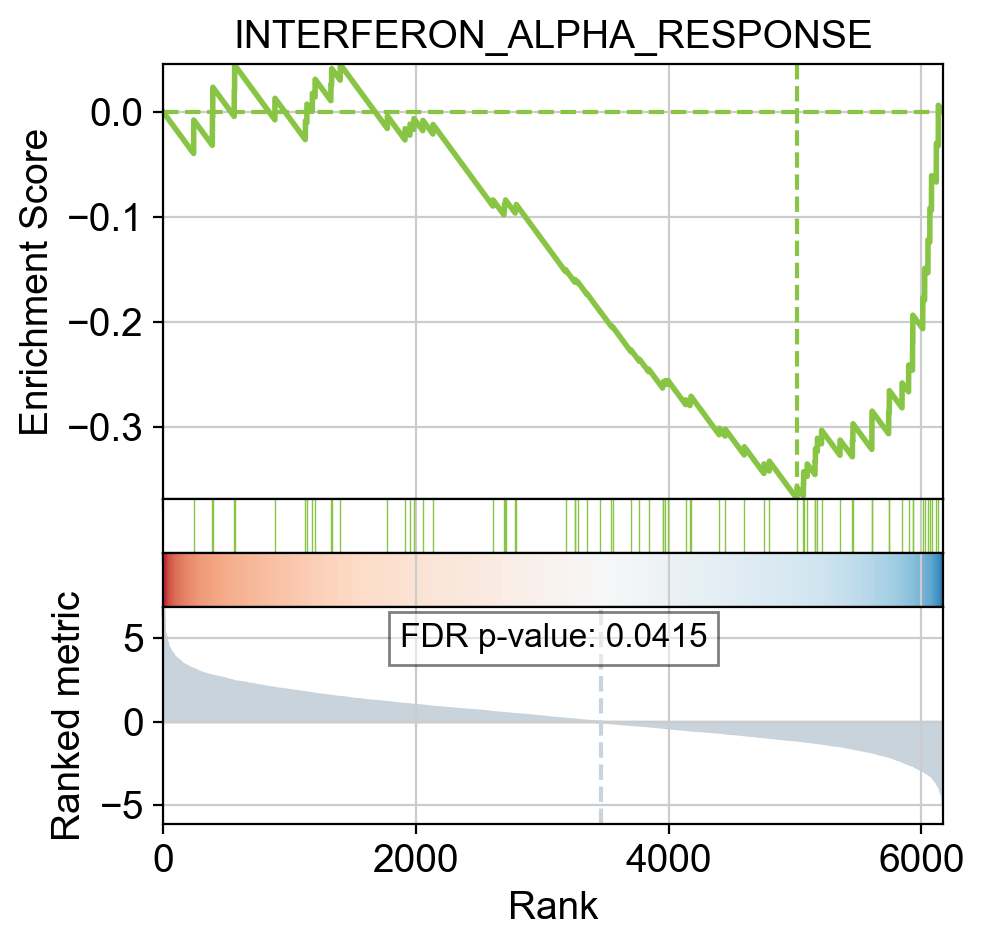

In [45]:
import matplotlib.pyplot as plt

selected_terms = ["TNFA_SIGNALING_VIA_NFKB", "ALLOGRAFT_REJECTION", "UV_RESPONSE_UP", "INTERFERON_GAMMA_RESPONSE", "APOPTOSIS", "INTERFERON_ALPHA_RESPONSE"]


for set_name in selected_terms:
    print(set_name)

    # Extract FDR p-value
    fdr_pval = gsea_hallmark.loc[gsea_hallmark['Term'] == set_name, 'FDR p-value'].values
    if len(fdr_pval) > 0:
        fdr_pval_text = f"FDR p-value: {fdr_pval[0]:.3g}"
    else:
        fdr_pval_text = "FDR p-value: N/A"

    # Create the plot
    fig = dc.plot_running_score(
        df=results_df,
        stat='stat',
        net=msigdb_filtered,
        source='geneset',
        target='genesymbol',
        set_name=set_name,
        return_fig = True
    )


    axes = fig[0].get_axes() 
    main_ax = axes[3]

    xlim = main_ax.get_xlim()
    ylim = main_ax.get_ylim()
    x_center = (xlim[0] + xlim[1]) / 2
    y_center = 5

    main_ax.text(x_center, y_center, fdr_pval_text, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    plt.savefig(f"figures/final/gsea/pseudobulk_aged_neutrophils_AML_vs_HD_{set_name}.pdf")


# PROGENy

In [46]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


In [47]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
Aged Neutrophils,1.673943,-2.669546,0.579029,-0.27947,-2.774912,0.000671,0.241082,2.802489,0.675473,-2.418196,-2.146622,-0.944631,1.771991,-3.208676


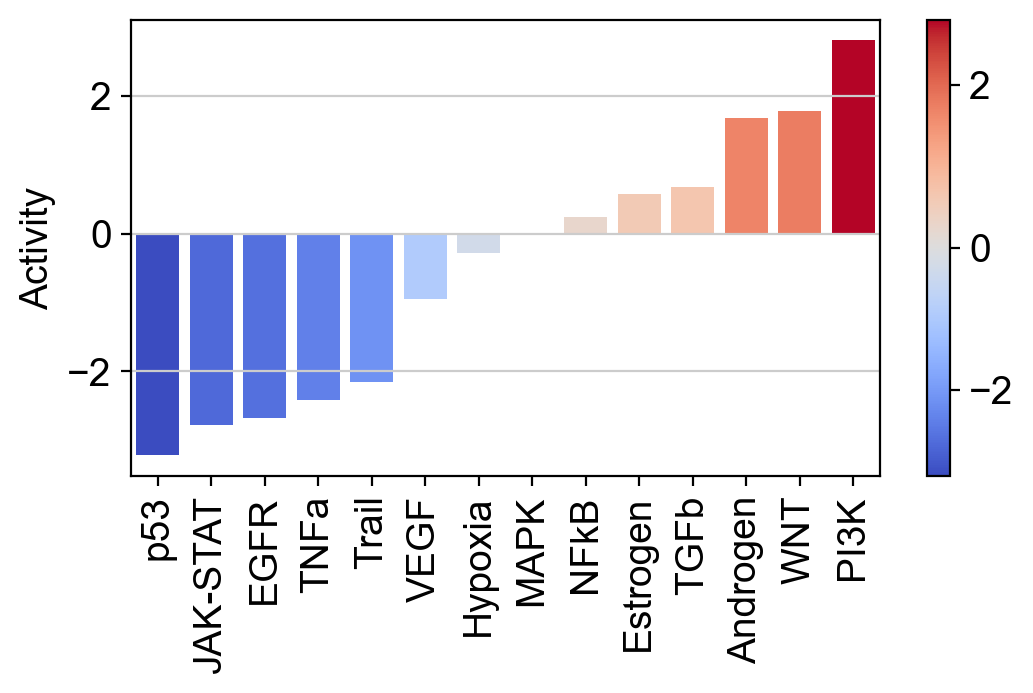

In [48]:
fig = dc.plot_barplot(
    acts=pathway_acts,
    contrast="Aged Neutrophils",
    top=25,
    vertical=False,
    figsize=(6, 3), return_fig=True
)
# NES - normalized enrichment score
plt.savefig("figures/final/pathway/pathways_activity_score_aged_neutrophils_aml_vs_hd.pdf", transparent = True, bbox_inches="tight")




# CollecTRI

In [51]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [52]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID4A,ARID4B,ARNT,ARX,...,ZNF143,ZNF148,ZNF331,ZNF350,ZNF354C,ZNF362,ZNF382,ZNF699,ZNF804A,ZNF91
Aged Neutrophils,-1.756248,-0.381507,-2.132324,-1.213523,-2.261309,1.370935,-1.056931,0.676589,2.004626,0.899976,...,-0.30442,-1.75885,-0.607796,-0.417805,-0.250923,-0.320084,-0.991121,-0.825923,-1.011896,-2.133481


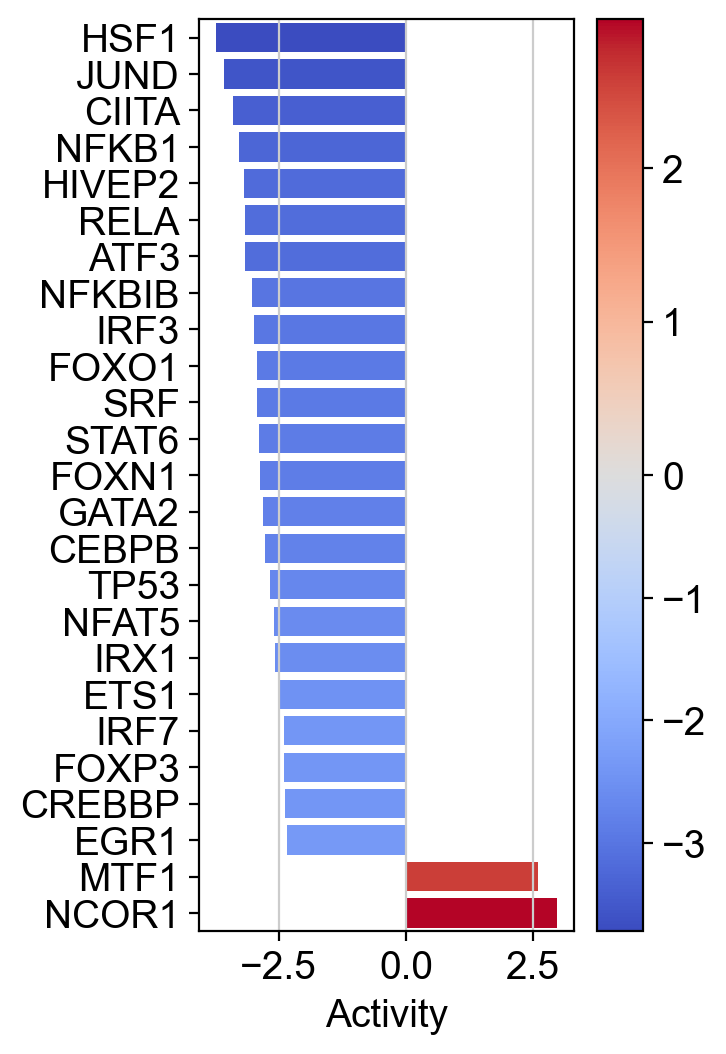

In [53]:
dc.plot_barplot(
    acts=tf_acts,
    contrast="Aged Neutrophils",
    top=25,
    vertical=True,
    figsize=(3, 6)
)

plt.savefig("figures/final/tf/tf_activity_score_aged_neutrophils_aml_vs_hd.pdf", transparent = True, bbox_inches="tight")

